# USD Cash Inflow Modelling

### 1. Importing used packages and modules

In [1]:
# functionality
import numpy as np
import pandas as pd
import pickle
from warnings import simplefilter

# plotting and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# ggplot utilities
from plotnine import ggplot, xlab, ylab, ggtitle, aes, theme, geom_boxplot

# interactive visualizations
from ipywidgets import interact
import ipywidgets as widgets
from itables import show

# helper tools
from visualization import *
from modeling import *

# time series modeling and analysis
from sktime.forecasting.compose import make_reduction

# modeling
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.forecasting.base import ForecastingHorizon
from lightgbm import LGBMRegressor

# sklearn models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# sktime models
from sktime.forecasting.model_selection import ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet

# metrics and evaluation
from sktime.performance_metrics.forecasting import mean_absolute_error

# settings and configurations
plt.style.use('Solarize_Light2')

# setting some options for visualization
pd.options.display.float_format = '${:,.2f}'.format

plt.style.use('Solarize_Light2')

### 2. Loading the data

In [2]:
usd_cash_inflow_df = pd.read_excel("../data/raw/cash_data.xlsx")

# transform the column names to a more computer format
usd_cash_inflow_df.columns = [x.replace(" ", "_") for x in usd_cash_inflow_df.columns.str.lower()]

# filter only usd
usd_mask = usd_cash_inflow_df["currency"] == "USD"
usd_cash_inflow_df = usd_cash_inflow_df[usd_mask][["date", "cash_inflow"]]

usd_cash_inflow_df = (usd_cash_inflow_df
 .assign(date=pd.to_datetime(usd_cash_inflow_df["date"]))
 .sort_values(by="date")
)

# add different time dependent features; it can be extended
usd_cash_inflow_df = add_time_features(usd_cash_inflow_df)

# visualize the table
show(usd_cash_inflow_df)

# get start and end dates for setting the index with more information
start_date = min(usd_cash_inflow_df["date"])
last_date = max(usd_cash_inflow_df["date"])
index_date_range = pd.date_range(start_date, last_date, freq='D')

# reindex for easier use with sktime
usd_cash_inflow_df = (usd_cash_inflow_df
 .set_index(index_date_range)
 .drop(columns="date")
)

c:\Users\Nikola_Shahpazov\projects\cash\notebooks\modeling.py:83: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


### 3. Cross-validation strategy

We are going to use the last 180 days for our final model selection, by separating it into 3 folds, each of 90 days, in order to have a better estimate on the out-of-sample error and to have a better representation on the production environment. The rest of the data we are going to use for training and hyper-parameter tunning.

It's a good practice to have a validation set used for tuning the hyper parameters of the explored and used models and also have a cross-validation set for choosing the final model based on some chosen metrics. The fact that the hyper parameters become part of the models by tuning them on a validation sets makes us choose a cross-validation strategy where the hyper-parameter optimizaiton set differs from the out-of-sample final metric calculation set.

### 3.1. Initial train and test set split

In [3]:
y_cash_inflow = usd_cash_inflow_df["cash_inflow"]
X_cash_inflow = usd_cash_inflow_df.drop(columns="cash_inflow")

# split the dataset into training and test, where the test should be 90 days
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y_cash_inflow,
    X=X_cash_inflow,
    test_size=90,
)

### 3.2 Cross-validation strategy for model selection strategy

We need to use the training set to train our models, while in the same time tune our parameters. We are going to use a
3-fold cross-validation strategy with and expanding window with initial training window of 461 elements, where each fold has some overlapping with the previous.

Since our hyper parameter tuning test sets (folds) should be separate from our model selection folds,
we are going to use the initial window of 461 elements for further hyperparameter cross-validation.  

Text(0.5, 1.0, 'Cross validation strategy for model selection')

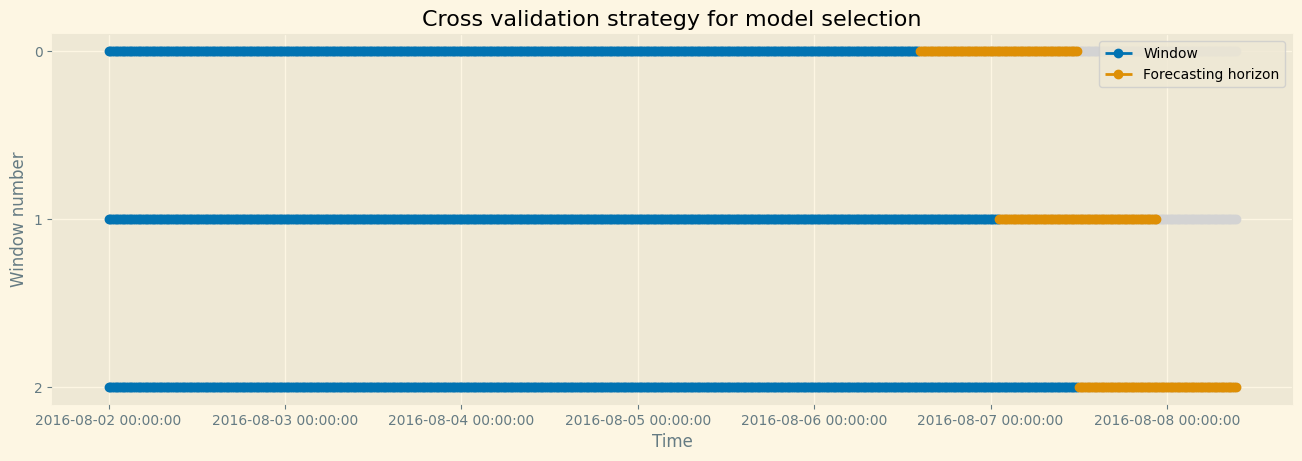

In [4]:
forecast_horizon = list(range(1, 91))
model_selection_cv = ExpandingWindowSplitter(
    initial_window=460,
    step_length=45,
    fh=forecast_horizon,
)

model_selection_splits = model_selection_cv.get_n_splits(y_train)

# visualize our model selection cross validation strategy
train_windows, test_windows = get_windows(y_train, model_selection_cv)
ax = plot_windows(y_train, train_windows, test_windows)
ax.set_title("Cross validation strategy for model selection")

### 3.3. Cross Validation Strategy for Hyper parameter tuning

As we want our test folds from our hyper parameter tuning to be disjoint of the test folds of the model selection testing folds, we
do another cross validation, internal of the initial training set for the model selection process.

That way we make 100 percent sure, that there's not going to be any data leakage with respect to the temporal nature of the dataset.

Text(0.5, 1.0, 'Cross validation strategy for Hyper Parameter tuning')

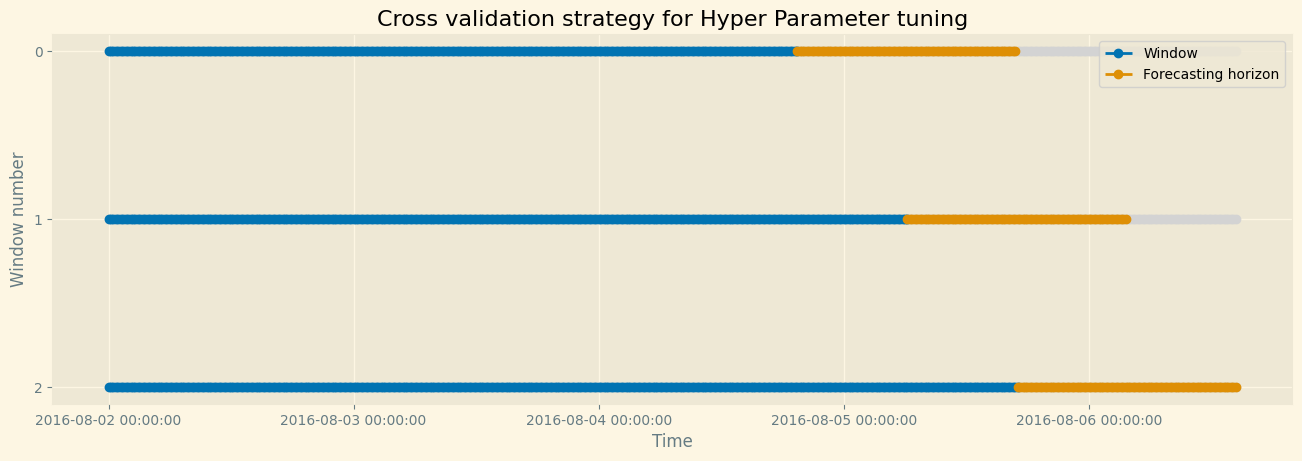

In [5]:
initial_model_selection_y = y_train.head(461)
initial_model_selection_X = X_train.head(461)
forecast_horizon = ForecastingHorizon(list(range(90)))

tune_cv = ExpandingWindowSplitter(
    initial_window=282,
    step_length=45,
    fh=forecast_horizon,
)

# visualize our model hyper parameter cross validation strategy
hyper_param_splits = tune_cv.get_n_splits(initial_model_selection_y)
train_windows, test_windows = get_windows(initial_model_selection_y, tune_cv)
ax = plot_windows(initial_model_selection_y, train_windows, test_windows)
ax.set_title("Cross validation strategy for Hyper Parameter tuning")

### 4. Hyperparameter Optimization

We are going to apply hyperparameter tuning with a simple `Grid Search scheme` on some of the models which are highly depenedent on their hyperparameters. That way, when we compare different models in the model selection stage, we can compare them at their actual glory.
 

In [6]:
%%capture

# forecasters definition. it can be extended
lgbm = make_reduction(estimator=LGBMRegressor(), window_length=5, strategy="recursive")
rf = make_reduction(estimator=RandomForestRegressor(), window_length=5, strategy='recursive')

# define hashmap with the models and the parameter grids to be looked in
forecasters_to_be_optimized = {
    "LightGBM": {
        "forecaster": lgbm, 
        "grid": {
            "window_length" : [75, 100, 125],
            "estimator__num_boost_round": [20, 30, 40, 50, 60],
            "estimator__num_leaves": list(range(1, 20, 10)),
            "estimator__max_depth": list(range(2, 10)),
            "estimator__reg_lambda":  [55, 60, 65],
        }
    },
    "RandomForest": {
        "forecaster": rf,
        "grid": {
            "window_length" : [75, 100, 125],
            'estimator__max_depth': [100, None],
            'estimator__min_samples_leaf': [1, 2, 4],
            'estimator__min_samples_split': [2, 5, 10],
        }
    },
    # list can be extended further with other models
}

# create the hyperparamter tuning cross validation strategy
hyper_param_tuning_cv = ExpandingWindowSplitter(
    initial_window=282,
    step_length=45,
    fh=list(range(1, 91)),
)

# tune the set of models we have defined above
optimized_forecasters = tune_forecasters(
    forecasters=forecasters_to_be_optimized,
    cross_validation=hyper_param_tuning_cv,
    y=initial_model_selection_y,
    X=initial_model_selection_X,
)

### 5. Additional Models

Here we are going to define some additional models for which we are not going to apply any hyper parameter optimization. The list of models can be of course, extended.

In [7]:
positive_ridge = PositiveRidge(alpha=0.5)
ridge_forecaster = make_reduction(estimator=positive_ridge, strategy='recursive', window_length=90)

# extend the hash of forecasters with some other models
forecasters = optimized_forecasters | {
  "PositiveRidgeRegression": ridge_forecaster,
  "DecisionTreeRegressor": make_reduction(estimator=DecisionTreeRegressor()),
  "TBATS": TBATS(use_box_cox=False, use_trend=True, sp=[7, 7], use_arma_errors=False, n_jobs=1),
  "Prophet": Prophet(yearly_seasonality=False, daily_seasonality=True),
}

print("Models:")
list(forecasters.keys())

Models:


['LightGBM',
 'RandomForest',
 'PositiveRidgeRegression',
 'DecisionTreeRegressor',
 'TBATS',
 'Prophet']

### 6. Model Evaluation

We are going to use our model selection cross validation strategy that we have defined earlier in order to compare different models. Using a Cross Validation with different folds would help us reduce bias when estimating the out of sample error.

In [ ]:
%%capture
# Evaluate different models on the evaluation set for model selection purposes

evaluation_df = evaluate_forecasters(
    forecasters=forecasters,
    y=y_train,
    X=X_train,
    cv=model_selection_cv,
    scoring=MeanAbsoluteError(),
)

In [9]:
show(evaluation_df)

We can see that our best model in terms of `mean absolute error` seems to be the `LightGBM` model.

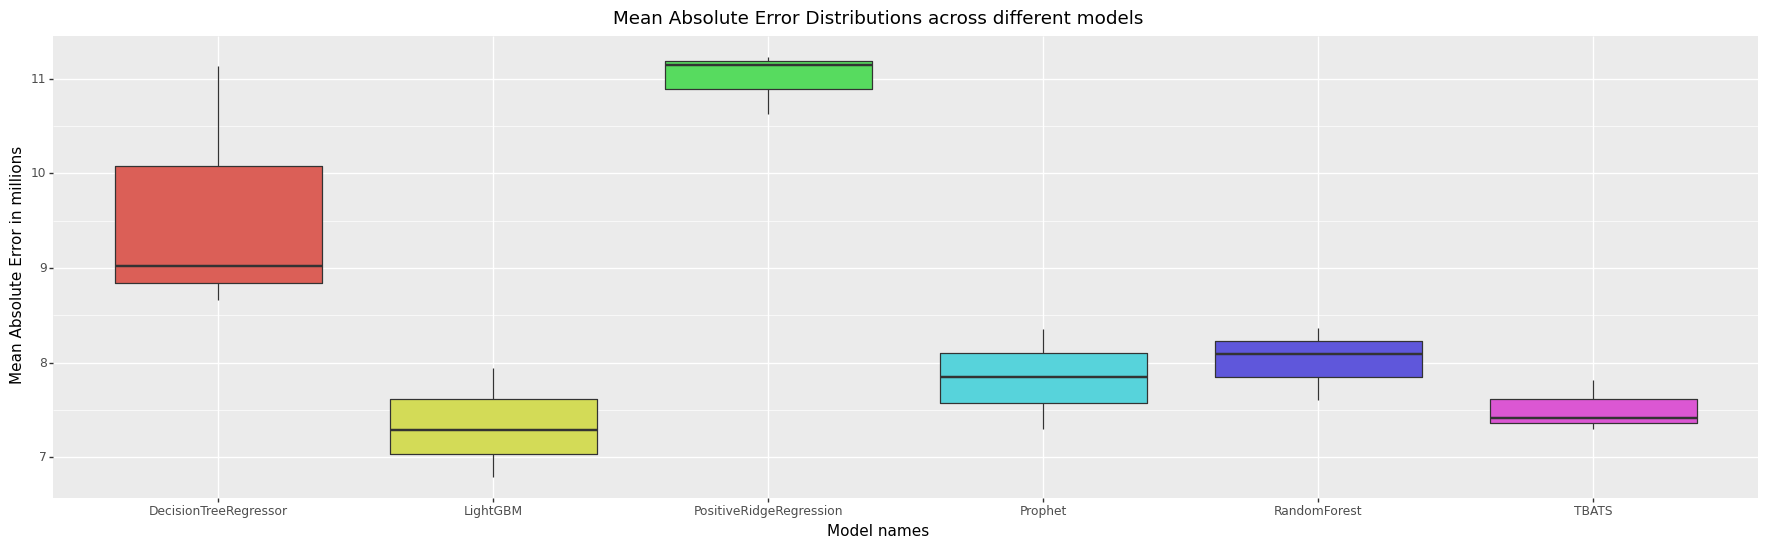

<ggplot: (136555991462)>

In [10]:
(evaluation_df
 .assign(test_MeanAbsoluteError=lambda df: df["test_MeanAbsoluteError"] / 1000000)
 .pipe(ggplot) +
    aes(x="forecaster_name", y="test_MeanAbsoluteError", fill="forecaster_name") +
    geom_boxplot() +
    theme(figure_size=(22, 6), legend_position="none") +
    ggtitle("Mean Absolute Error Distributions across different models") +
    xlab("Model names") +
    ylab("Mean Absolute Error in millions")
)

### 7. Final Fitting of the models

To get a final out of sample estimation, we need to refit the models on the entire train set we have and to estimate the out of sample error on the test set

In [ ]:
%%capture
# Fit the forecasters:
[model.fit(y_train, X_train) for _, model in forecasters.items()];
# define a 90 days ahead horizon for forecasting
three_months_ahead_horizon = ForecastingHorizon(y_test.index, is_relative=False)
forecasts = get_forecasts(models=forecasters, horizon=three_months_ahead_horizon, X_test=X_test)

# define different metrics to check performances of the models
metrics = {
    'RMSE': MeanSquaredError(square_root=True),
    'MAE':  mean_absolute_error,
}

metrics_results = get_metrics_results(metrics, forecasts, y_test);


In [12]:
show(metrics_results)

We can see that our chosen LightGBM model is still the best when it comes on mean absolute error on the test set. 

In [13]:
def show_best_n(metric: str, n: int, model="all"):
    return plot_best_n_models(metrics_results, forecasts, y_test, metric, n, model)

interact(
    show_best_n,
    metric=["RMSE", "MAE"],
    n=range(1, 10),
    model=["all"] + list(forecasters.keys()),
)

interactive(children=(Dropdown(description='metric', options=('RMSE', 'MAE'), value='RMSE'), Dropdown(descript…

<function __main__.show_best_n(metric: str, n: int, model='all')>

### 8. Final model training

We are going to export the final model trained on the entire set with produced forecasts.

In [14]:
# fit final model
final_model = forecasters["LightGBM"]
final_model.fit(y=y_cash_inflow, X=X_cash_inflow)

# prepare future dataset
start_future = y_cash_inflow.index.max() + pd.Timedelta(days=1)
future_dates = pd.date_range(start_future, periods=90, freq="D")
X_future = add_time_features(pd.DataFrame({"date": future_dates}))

# produce future predictions
future_predictions = final_model.predict(
    fh=list(range(1, 91)),
    X=X_future.drop(columns="date"),
)
future_predictions_positive = np.where(future_predictions < 0, 0, future_predictions)
future_predictions_df = pd.DataFrame({
    "Date": future_predictions.index,
    "Prediction": future_predictions_positive, 
}) 

show(future_predictions_df)

# save the model and the final predictions
with open('../data/output/final_model.pickle', 'wb') as handle:
    pickle.dump(forecasters["LightGBM"], handle, protocol=pickle.HIGHEST_PROTOCOL)

future_predictions_df.to_csv("../data/output/final_predictions_90_days.csv")

[LightGBM] [Warning] num_iterations is set=60, num_boost_round=60 will be ignored. Current value: num_iterations=60


c:\Users\Nikola_Shahpazov\projects\cash\notebooks\modeling.py:83: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


### 9. Further Steps of Improvement and Research

Obviously, the current analysis can be improved in numerous ways. For starters, here are some steps by which the analysis can be improved.

* The Analysis can be encapsulated in a `MLFlow project` and thus establishing reproducibility. A final reproducible analysis can be presented in a `Markdown` document with a script which runs each of the steps of the analysis with given parameters for experiment tracking and reproducibility.
* Introducing an optimization library for the hyper parameter tuning, e.g. `Optuna`, `Hyperopt`, `Katib`, etc. This way the grid search of the models can be extended a lot with decreased computation time for the parameter search.
* Probabalistic Time Series Modeling - Probabilistic Time Series modeling has been gaining it's momentum lately and it's interesting to see how such models would perform on the given dataset.
* Better Ensemble model from the best models.
* Feature Engineering - Here we generated a small fraction of possible features, mostly from the time index, e.g. `weekday`, `month`, etc. The `sktime` library gives us the opportunity to apply different tabular models to our time series by generating lags which are used as features and further generated from predictions recursively. We can further extend that by extending the feature space with `trend`, `rolling aggregations`, etc 
* Model Interpretability - The current model doesn't have interpretation on the final model. It's interesting to know why the model makes particular predictions. This analysis is especially valuable for business clients wanting to make sense of the model.
